# GAN Architecture with Attention

PENDING
- which losses for intermediary (approx) network?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import pickle
import os
from pathlib import Path
import tensorflow as tf

from keras.layers import Dense, Dropout, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
cars_mask_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_masks.pickle')
cars_original_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_original.pickle')

In [3]:
with open(cars_mask_path, 'rb') as file:
    X_mask = pickle.load(file)
    
print(X_mask.shape)

(16185, 3, 64, 64)


In [4]:
with open(cars_original_path, 'rb') as file:
    X_original = pickle.load(file)
    
print(X_original.shape)

(16185, 3, 64, 64)


In [9]:
n_train = 100

def load_data():
    X_train, X_train_mask = X_original[:n_train], X_mask[:n_train]
    X_train = X_train.transpose((0, 2, 3, 1))
    X_train_mask = X_train_mask.transpose((0, 2, 3, 1))
    #X_train = X_train[:, :, :, 0]
    #X_train_mask = X_train_mask[:, :, :, 0]
    #X_train = X_train.reshape(X_train.shape[0], -1)
    #X_train_mask = X_train_mask.reshape(X_train.shape[0], -1)
    return (X_train, X_train_mask)

(X_train, X_train_mask) = load_data()
print(X_train.shape)
print(X_train_mask.shape)

(100, 64, 64, 3)
(100, 64, 64, 3)


In [99]:
n_train = 400

def load_test_data():
    X_train, X_train_mask = X_original[n_train:2*n_train], X_mask[n_train:2*n_train]
    X_train = X_train.transpose((0, 2, 3, 1))
    X_train_mask = X_train_mask.transpose((0, 2, 3, 1))
    #X_train = X_train[:, :, :, 0]
    #X_train_mask = X_train_mask[:, :, :, 0]
    #X_train = X_train.reshape(X_train.shape[0], -1)
    #X_train_mask = X_train_mask.reshape(X_train.shape[0], -1)
    return (X_train, X_train_mask)

(X_test, X_test_mask) = load_test_data()
print(X_test.shape)
print(X_test_mask.shape)

(400, 64, 64, 3)
(400, 64, 64, 3)


# First Net: Approximation of the masked region

A first network approximates the shapes in the masked region of the input image, in oreder to help the training of the Attention layer of the following GAN

In [182]:
def create_approx_net():
    approx = Sequential()
    
    approx.add(Dense(units=512, input_dim=4096))
    approx.add(LeakyReLU(0.2))
    
    approx.add(Dense(units=100))
    approx.add(LeakyReLU(0.2))
    
    approx.add(Dense(units=512))
    approx.add(LeakyReLU(0.2))
    
    approx.add(Dense(units=4096, activation='tanh'))
    
    approx.compile(loss=keras.losses.mean_absolute_error, optimizer=Adam(lr=0.0002, beta_1=0.5))
    return approx

def create_approx_net_conv():
    approx = Sequential()
    
    approx.add(Conv2D(filters=32, kernel_size=5, strides=1, padding='same', input_shape=(64, 64, 3, )))
    approx.add(ReLU())
    
    approx.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same'))
    approx.add(ReLU())
    
    approx.add(Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same'))
    approx.add(ReLU())
    
    approx.add(Conv2DTranspose(filters=3, kernel_size=5, strides=1, padding='same', 
               activation=keras.activations.sigmoid))
    
    approx.compile(loss=keras.losses.mean_absolute_error, optimizer=Adam(lr=0.0002, beta_1=0.5))
    return approx

a = create_approx_net_conv()
a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 32)        2432      
_________________________________________________________________
re_lu_28 (ReLU)              (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
re_lu_29 (ReLU)              (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 64, 64, 32)        51232     
_________________________________________________________________
re_lu_30 (ReLU)              (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 64, 64, 3)         2403      
Total para

In [209]:
for i in range(100):
    a.train_on_batch(X_train_mask, X_train)
    print(i)

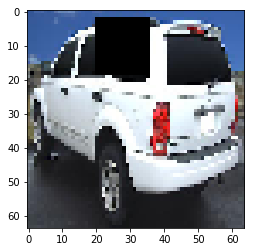

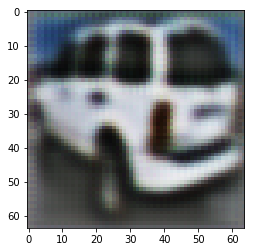

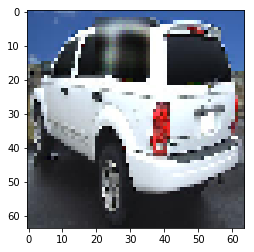

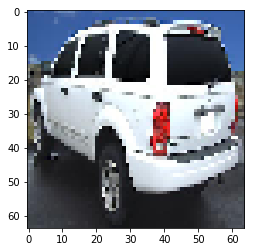

In [208]:
# RGB
img = np.random.randint(0, 400)

pred = a.predict_on_batch(X_test)[img]

plt.imshow(X_test_mask[img], vmin=0., vmax=1.)
plt.show()
plt.imshow(pred, vmin=0., vmax=1.)
plt.show()
is_masked = X_test_mask[img]==0.
plt.imshow((pred*is_masked)+ X_test_mask[img], vmin=0., vmax=1.)
plt.show()
plt.imshow(X_test[img], vmin=0., vmax=1.)
plt.show()

In [ ]:
# No RGB
img = np.random.randint(0, 100)

plt.imshow(X_test_mask[img].reshape(64, 64), vmin=0., vmax=1.)
plt.show()
plt.imshow(a.predict_on_batch(X_test)[img].reshape(64, 64), vmin=0., vmax=1.)
plt.show()
is_masked = X_test_mask[img]==0.
plt.imshow((a.predict_on_batch(X_test)[img]*is_masked).reshape(64, 64)+ X_test_mask[img].reshape(64, 64), vmin=0., vmax=1.)
plt.show()

# Second Net: GAN + Attention

In [ ]:
def attention_net():
    attention = Sequential()

In [ ]:
def full_net():
    